In [ ]:
# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
# utils
import os
import torchvision.models as models

from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from torchmetrics import Accuracy, Precision, Recall, F1Score

In [127]:
# global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"
train_path = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"
image_size = (224,224)
num_classes = 4
train_paths = glob(f"{train_path}/*/*.jpg")
test_paths = glob(f"{test_path}/*/*.jpg")

In [128]:
# check device
device

'cuda'

In [129]:
# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [135]:
# custom dataset class
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [136]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)

In [137]:
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5, random_state=ord("H"))

In [138]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [139]:
vgg = models.vgg16(pretrained=True)

num_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(num_features, num_classes)



In [140]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [141]:


def train_epoch():
    model.train()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    for batch_number, (images, labels_indices, labels) in enumerate(train_loader):
        images, labels_indices = images.to(device), labels_indices.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels_indices)
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels_indices.size(0)
        total_correct += (predicted == labels_indices).sum().item()
        
        loss.backward()
        optimizer.step()
        
        if (batch_number and batch_number % 150 == 0):
            c_loss = total_loss / (batch_number + 1)
            accuracy = total_correct / total_predictions
            print(f"Batch {batch_number}/{len(train_loader)}, Loss: {c_loss:0.4f}, Accuracy: {accuracy * 100:.2f}%")
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy


In [142]:
def eval_model():

    model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():

        for batch_number, (images, labels_indices, labels) in enumerate(val_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()

            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy


In [143]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_rec = []
val_rec = []

In [144]:
best_score = float("inf")
n_epochs = 10
tolerance = 0

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"model_{epoch+1}")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    train_rec.append(train_recall)
    val_rec.append(eval_recall)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")
    print("#" * 70)


Epoch 0,   Batch 150/179, Loss: 0.0868, Accuracy: 97.41%
Train Loss: 0.0863, Train Accuracy: 97.36%
Eval Loss: 0.0817, Eval Accuracy: 97.86%
######################################################################
Epoch 1,   Batch 150/179, Loss: 0.0737, Accuracy: 97.74%
Train Loss: 0.0702, Train Accuracy: 97.93%
Eval Loss: 0.0824, Eval Accuracy: 97.40%
######################################################################
Epoch 2,   Batch 150/179, Loss: 0.0557, Accuracy: 98.05%
Train Loss: 0.0557, Train Accuracy: 98.07%
Eval Loss: 0.0854, Eval Accuracy: 97.40%
######################################################################
Epoch 3,   Batch 150/179, Loss: 0.0719, Accuracy: 97.58%
Train Loss: 0.0669, Train Accuracy: 97.72%
Eval Loss: 0.0857, Eval Accuracy: 97.56%
######################################################################
Epoch 4,   Batch 150/179, Loss: 0.0607, Accuracy: 98.12%
Train Loss: 0.0649, Train Accuracy: 98.11%
Eval Loss: 0.1046, Eval Accuracy: 96.79%
###########

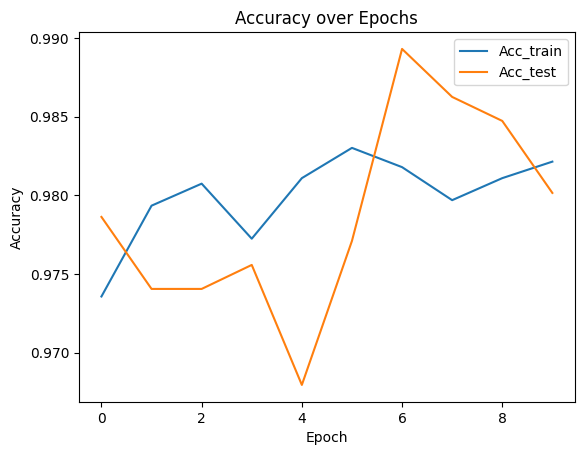

In [145]:
plt.plot(train_accuracies, label='Acc_train')
plt.plot(val_accuracies, label='Acc_test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()